<a href="https://colab.research.google.com/github/JairEsc/Aprendizaje/blob/main/CAMDA/SVM_NN_datos_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio de clasificación
### Utilizando datos de CAMDA 2023, considerando como variable de clasificación "City", consideraremos un modelo híbrido de máquinas de soporte vectorial y redes neuronales.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
otus=pd.read_csv('camda_relative.csv', index_col=0, low_memory=False)
print(otus.shape)
otus.head()

(286, 18295)


,ID_city,City,Latitude,Longitude,Climate,Year,468,469,28090,2708348,...,1146874,1519389,12480,1131,2886895,546184,12330,1922682,1513254,1922952
ID,,,,,,,,,,,,,,,,,,,,,
CAMDA23_MetaSUB_gCSD16_AKL_10,AKL,Auckland,-36.75,174.75,Cfb,2016,0.048249,10.696605,14.560432,1.407184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_11,AKL,Auckland,-36.75,174.75,Cfb,2016,0.038155,0.527739,0.041985,0.006187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_12,AKL,Auckland,-36.75,174.75,Cfb,2016,0.002185,0.234138,0.051282,0.004188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_13,AKL,Auckland,-36.75,174.75,Cfb,2016,0.000142,0.014304,0.010763,0.001360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_14,AKL,Auckland,-36.75,174.75,Cfb,2016,0.002103,0.061997,0.079509,0.003771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocesamiento de la base:
Encontramos unas entradas de tipo string. Removemos las columnas correspondientes

In [15]:
X_names = otus.drop(['ID_city','City','Latitude','Longitude','Climate','Year'],axis=1).columns
drops=[]
for name in X_names:
    if('\x10.001308923774823973' in np.array(otus[name]) or '0.001215429219479$037' in np.array(otus[name]) ):
        otus=otus.drop(name,axis=1)
        X_names=X_names.drop(name,axis=1)
        drops.append(name)
#Aquí podriamos hacer selección de muestras. E.g. aquellas etiquetas con al menos $N$ muestras.
print("Después: ",otus.shape)

Después:  (286, 18293)


Exploramos el balance de clases a considerar

<ipython-input-17-8202315d1e17>:1: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  plt.bar(otus['City'].value_counts().index.ravel(),otus['City'].value_counts(),)


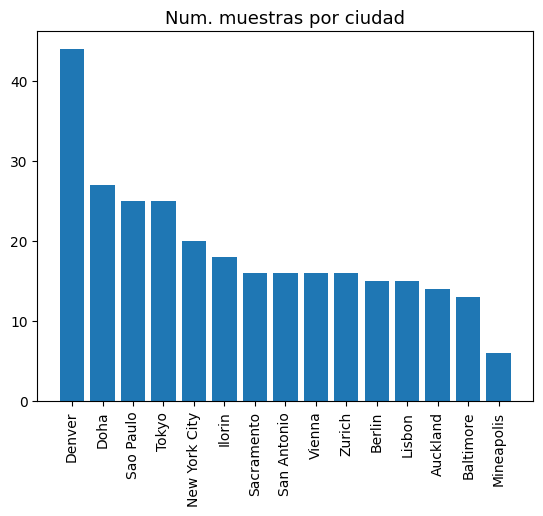

In [17]:
plt.bar(otus['City'].value_counts().index.ravel(),otus['City'].value_counts(),)
plt.title("Num. muestras por ciudad", fontsize=13)
plt.tick_params(axis='x', labelrotation=90)

plt.show()

### El shape=(286,18293) nos indica que hay 286 muestras, repartidas en 15 ciudades.

In [7]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.3 MB/s eta 0:00:00


In [8]:
import contextily as ctx
import geopandas as gpd
import numpy as np
conteo_por_ciudad=[]
for p in otus['City'].value_counts():
  conteo_por_ciudad+=list(np.repeat(p,p))

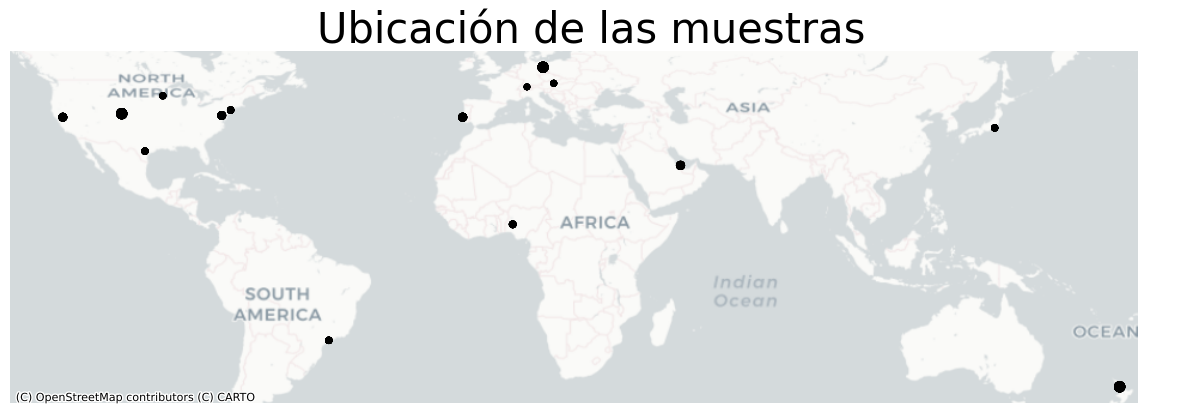

In [ ]:
otus_gdf = gpd.GeoDataFrame(otus.copy(), geometry=gpd.points_from_xy(otus['Longitude'], otus['Latitude']), crs='EPSG:4326')
fig, ax = plt.subplots(1, figsize=(15, 15))
otus_gdf.plot(marker='.', c='black', ax=ax, markersize=(np.array(conteo_por_ciudad)/np.max(conteo_por_ciudad))*200, zorder=1)
plt.title("Ubicación de las muestras",fontsize=30)
plt.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326')

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

## Primera clasificación.
Al ser "Denver" la ciudad con más muestras, utilizamos el método de soporte vectorial

In [79]:
X = otus[X_names]
Y_total_city=np.array(otus['City']).ravel()
otus['City_binary']=['Denver' if x=='Denver' else 'No-Denver' for x in otus['City']]
Y_total_Denver=np.array(otus['City_binary']).ravel()
X_train, X_test, y_train_id, y_test_id = train_test_split(X, np.arange(0,len(Y_total_city)), test_size=0.3, random_state=0)

In [80]:
Y_train=np.array(otus['City']).ravel()[y_train_id]
Y_test=np.array(otus['City']).ravel()[y_test_id]

<ipython-input-38-8bb33b4d9717>:1: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  plt.bar(otus['City_binary'].value_counts().index.ravel(),otus['City_binary'].value_counts(),)


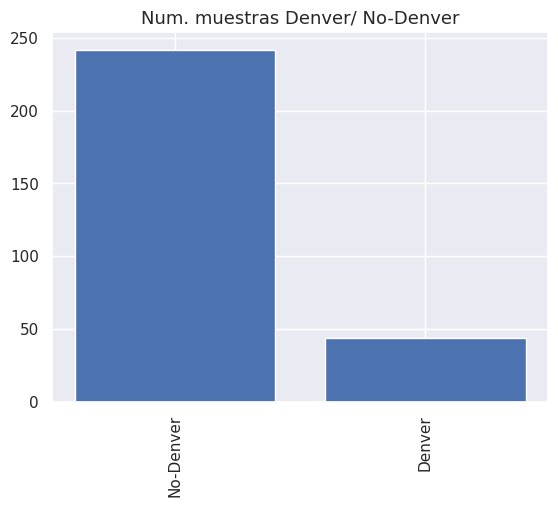

In [38]:
plt.bar(otus['City_binary'].value_counts().index.ravel(),otus['City_binary'].value_counts(),)
plt.title("Num. muestras Denver/ No-Denver", fontsize=13)
plt.tick_params(axis='x', labelrotation=90)

plt.show()

In [32]:
import seaborn as sns
sns.set()
from sklearn.svm import SVC # Support vector classifier
from sklearn.datasets import make_blobs

In [47]:
model_svm = SVC(kernel='linear', C=1E10)
Y_train_binary=['Denver' if x=='Denver' else 'No-Denver' for x in Y_train]
le = preprocessing.LabelEncoder()
le.fit(Y_train_binary)
#le.classes_
y_cat_city = le.transform(Y_train_binary)
model_svm.fit(X_train, Y_train_binary)


SVC(C=10000000000.0, kernel='linear')

In [59]:
y_pred=model_svm.predict(X_test)
Y_test_binary=['Denver' if x=='Denver' else 'No-Denver' for x in Y_test]
np.sum(Y_test_binary==y_pred)/len(y_pred)

0.8953488372093024

El modelo SVM clasifica como Denver o No-Denver con 0.89 de precisión.

## A continuación definimos el modelo de multilayer perceptron para clasificar a las ciudades No-Denver

In [66]:
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
from keras import models
import tqdm
from time import time

In [95]:
_,idx = np.unique(Y_total_city,return_inverse=True)
from keras.utils import to_categorical
Y_total=to_categorical(idx)
X_train_NN=X_train[Y_train!='Denver']
X_test_NN=X_test[Y_test!='Denver']
Y_train_NN=[x for x in Y_train if x!='Denver']
Y_test_NN=[x for x in Y_test if x!='Denver']
_,idx = np.unique(Y_train_NN,return_inverse=True)
Y_train_NN=to_categorical(idx)
_,idx = np.unique(Y_test_NN,return_inverse=True)
Y_test_NN=to_categorical(idx)

In [96]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(18287,), name='Input_Layer'))#Obligatoria
model.add(layers.Dense(10, activation='linear'))# Numero de capas ocultas: Opcional
model.add(layers.Dense(10, activation='tanh'))# Numero de neuronas en cada capa: Opcional
model.add(layers.Dense(14, activation='Softmax', name='Output_Layer'))#Obligatoria
model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
import time
tic = time.time()

history=model.fit(x = X_train_NN,
           y = Y_train_NN,
          validation_data=[X_test_NN, Y_test_NN],batch_size=50,
           epochs=200,
           verbose=1,shuffle=True,)

print('seconds=', time.time()-tic)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 10)                182880    
                                                                 
 dense_27 (Dense)            (None, 10)                110       
                                                                 
 Output_Layer (Dense)        (None, 14)                154       
                                                                 
Total params: 183144 (715.41 KB)
Trainable params: 183144 (715.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
4/4 [==============================] - 2s 228ms/step - loss: 2.6870 - accuracy: 0.0783 - val_loss: 2.5560 - val_accuracy: 0.1974
Epoch 2/200
4/4 [==============================] - 0s 73ms/step - loss: 2.5193 - accuracy: 0.1325 - val_loss: 2.5130 - val_accuracy: 0.1

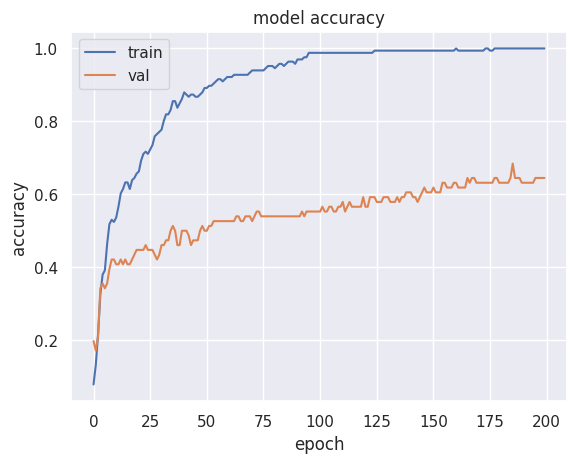

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [110]:
primera_prediccion=model_svm.predict(X_test)
indices = [ind for ind, ele in enumerate(primera_prediccion) if ele == 'No-Denver']
segunda_prediccion=np.argmax(model.predict(X_test.iloc[indices]),axis=1)
for i in range(len(indices)):
    primera_prediccion[indices[i]]=segunda_prediccion[i]
ultima_prediccion=[x if x=='Denver' else _[int(x)] for x in primera_prediccion]
ultima_prediccion

3/3 [==============================] - 0s 9ms/step


['Doha',
 'New York City',
 'Sacramento',
 'Sao Paulo',
 'San Antonio',
 'Denver',
 'New York City',
 'Tokyo',
 'Berlin',
 'Berlin',
 'Mineapolis',
 'Zurich',
 'Auckland',
 'Sacramento',
 'Sacramento',
 'San Antonio',
 'Sao Paulo',
 'New York City',
 'San Antonio',
 'Doha',
 'Ilorin',
 'Tokyo',
 'Doha',
 'Tokyo',
 'Baltimore',
 'Denver',
 'Sao Paulo',
 'Sao Paulo',
 'Denver',
 'New York City',
 'Sacramento',
 'Berlin',
 'Lisbon',
 'Tokyo',
 'Sacramento',
 'Denver',
 'Baltimore',
 'Baltimore',
 'Auckland',
 'Ilorin',
 'Lisbon',
 'Ilorin',
 'New York City',
 'Sao Paulo',
 'Denver',
 'Denver',
 'Ilorin',
 'Sao Paulo',
 'Denver',
 'Zurich',
 'Doha',
 'Zurich',
 'New York City',
 'Vienna',
 'Denver',
 'Zurich',
 'Denver',
 'Sacramento',
 'Denver',
 'Berlin',
 'Sao Paulo',
 'Mineapolis',
 'Vienna',
 'Denver',
 'Berlin',
 'Doha',
 'Tokyo',
 'Denver',
 'Sao Paulo',
 'Ilorin',
 'Ilorin',
 'Denver',
 'Denver',
 'Denver',
 'Sao Paulo',
 'Sao Paulo',
 'Doha',
 'Tokyo',
 'San Antonio',
 'Denver',
 

## Calcular la precisión

In [111]:
np.sum(Y_test==ultima_prediccion)/len(Y_test)

0.6511627906976745